In [1]:
!pip install psutil --q
!pip install gsutil --q
!pip install gputil --q
! pip install torch torchvision psutil -q


In [15]:
import torch
import gc
import psutil
import GPUtil

def get_system_resources():
    """
    Get current system resource usage.
    """
    cpu_percent = psutil.cpu_percent()
    ram_percent = psutil.virtual_memory().percent
    
    gpu_info = []
    if torch.cuda.is_available():
        gpus = GPUtil.getGPUs()
        for gpu in gpus:
            gpu_info.append({
                'id': gpu.id,
                'memory_total': gpu.memoryTotal,
                'memory_used': gpu.memoryUsed,
                'memory_free': gpu.memoryFree,
                'memory_util': gpu.memoryUtil * 100
            })
    
    return {
        'cpu_percent': cpu_percent,
        'ram_percent': ram_percent,
        'gpu_info': gpu_info
    }

def print_system_resources(resources):
    """
    Print system resources in a readable format.
    """
    print(f"CPU Usage: {resources['cpu_percent']}%")
    print(f"RAM Usage: {resources['ram_percent']}%")
    for gpu in resources['gpu_info']:
        print(f"GPU {gpu['id']}:")
        print(f"  Total Memory: {gpu['memory_total']} MB")
        print(f"  Used Memory: {gpu['memory_used']} MB")
        print(f"  Free Memory: {gpu['memory_free']} MB")
        print(f"  Memory Utilization: {gpu['memory_util']:.2f}%")

def gpu_cleanup():
    """
    Perform a thorough GPU memory cleanup and report system resources before and after.
    """
    print("System resources before cleanup:")
    resources_before = get_system_resources()
    print_system_resources(resources_before)

    print("\nPerforming GPU memory cleanup...")
    
    # Clear PyTorch's CUDA cache
    torch.cuda.empty_cache()

    # Force garbage collection
    gc.collect()

    # Explicitly clear any remaining CUDA memory
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            with torch.cuda.device(f'cuda:{i}'):
                torch.cuda.empty_cache()
                torch.cuda.ipc_collect()

    print("\nSystem resources after cleanup:")
    resources_after = get_system_resources()
    print_system_resources(resources_after)

    print("\nGPU memory cleanup completed.")

    # Calculate and print the difference
    print("\nMemory freed:")
    for before, after in zip(resources_before['gpu_info'], resources_after['gpu_info']):
        memory_freed = before['memory_used'] - after['memory_used']
        print(f"GPU {before['id']}: {memory_freed} MB")

# Example usage:
if __name__ == "__main__":
    # Your training code here
    
    # After training or when you need to clean up
    gpu_cleanup()

System resources before cleanup:
CPU Usage: 3.8%
RAM Usage: 26.5%
GPU 0:
  Total Memory: 16384.0 MB
  Used Memory: 124.0 MB
  Free Memory: 15992.0 MB
  Memory Utilization: 0.76%
GPU 1:
  Total Memory: 16384.0 MB
  Used Memory: 124.0 MB
  Free Memory: 15992.0 MB
  Memory Utilization: 0.76%

Performing GPU memory cleanup...

System resources after cleanup:
CPU Usage: 3.5%
RAM Usage: 26.5%
GPU 0:
  Total Memory: 16384.0 MB
  Used Memory: 124.0 MB
  Free Memory: 15992.0 MB
  Memory Utilization: 0.76%
GPU 1:
  Total Memory: 16384.0 MB
  Used Memory: 124.0 MB
  Free Memory: 15992.0 MB
  Memory Utilization: 0.76%

GPU memory cleanup completed.

Memory freed:
GPU 0: 0.0 MB
GPU 1: 0.0 MB


In [16]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [17]:
!python distributed_training.py

[W909 14:25:57.723805289 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
[W909 14:25:57.736019160 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
Rank 1, Epoch 0, Batch 0/98, Loss: 0.0082
GPU 1 Memory: 12498.0MB / 16384.0MB
GPU 1 Utilization: 90.00%
CPU Usage: 12.3%, RAM Usage: 28.7%
Rank 0, Epoch 0, Batch 0/98, Loss: 0.0076
GPU 0 Memory: 12498.0MB / 16384.0MB
GPU 0 Utilization: 100.00%
CPU Usage: 12.3%, RAM Usage: 28.7%
Rank 0, Epoch 0, Batch 10/98, Loss: 0.0025
GPU 0 Memory: 14478.0MB / 16384.0MB
GPU 0 Utilization: 100.00%
CPU Usage: 7.0%, RAM Usage: 28.7%
Rank 1, Epoch 0, Batch 10/98, Loss: 0.0025
GPU 1 Memory: 14478.0MB / 16384.0MB
GPU 1 Utilization: 100.00%
CPU Usage: 7.0%, RAM Usage: 28.7%
Rank 0, Epoch 0, Batch 20/98, Loss: 0.0011
GPU 0 Memory: 14478.0MB / 16384.0MB
GPU 0 Utilization: 100.00%
Rank 1, Epoch 0, Batch 20/98, Loss: 0.0015
GPU 1 Memory: 14478.0MB / 

# Adaptive Thread BenchMark Execution

In [1]:
import time
from concurrent.futures import ThreadPoolExecutor
import numpy as np

def get_optimal_thread_count(cpu_cores, max_threads=36):
    """
    Determine the optimal thread count based on CPU cores.
    For I/O-bound operations, we can use more threads than cores.
    """
    return min(cpu_cores * 4, max_threads)

def run_threaded_operation(operation, items, num_threads):
    """
    Run an operation on items using specified number of threads.
    """
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        return list(executor.map(operation, items))

def benchmark_threading(operation, items, cpu_cores):
    """
    Benchmark the operation with different thread counts and return the optimal.
    """
    optimal_threads = get_optimal_thread_count(cpu_cores)
    
    print(f"CPU cores: {cpu_cores}")
    print(f"Estimated optimal threads: {optimal_threads}")
    
    # Single-threaded baseline
    start = time.time()
    single_result = [operation(item) for item in items]
    single_time = time.time() - start
    print(f"Single-threaded time: {single_time:.2f} seconds")
    
    best_time = single_time
    best_threads = 1
    
    # Test different thread counts
    for thread_count in [4, 8, 12, 16, 20, 24, 28, 32, 36]:
        if thread_count > optimal_threads:
            break
        
        start = time.time()
        multi_result = run_threaded_operation(operation, items, thread_count)
        multi_time = time.time() - start
        speedup = single_time / multi_time
        
        print(f"Threads: {thread_count}, Time: {multi_time:.2f} seconds, Speedup: {speedup:.2f}x")
        
        if multi_time < best_time:
            best_time = multi_time
            best_threads = thread_count
    
    print(f"\nOptimal thread count: {best_threads}")
    print(f"Best speedup: {single_time / best_time:.2f}x")
    
    return best_threads

# Example usage
if __name__ == "__main__":
    # Simulated I/O-bound operation
    def io_bound_operation(x):
        time.sleep(0.1)  # Simulate I/O operation
        return x * 2

    items = list(range(1000))  # 1000 items to process
    cpu_cores = 8  # Adjust this based on your system

    optimal_threads = benchmark_threading(io_bound_operation, items, cpu_cores)
    
    print("\nUsing optimal thread count for final run:")
    start = time.time()
    final_result = run_threaded_operation(io_bound_operation, items, optimal_threads)
    final_time = time.time() - start
    print(f"Final run time: {final_time:.2f} seconds")


CPU cores: 8
Estimated optimal threads: 32
Single-threaded time: 100.25 seconds
Threads: 4, Time: 25.08 seconds, Speedup: 4.00x
Threads: 8, Time: 12.54 seconds, Speedup: 7.99x
Threads: 12, Time: 8.43 seconds, Speedup: 11.90x
Threads: 16, Time: 6.32 seconds, Speedup: 15.85x
Threads: 20, Time: 5.02 seconds, Speedup: 19.97x
Threads: 24, Time: 4.22 seconds, Speedup: 23.76x
Threads: 28, Time: 3.62 seconds, Speedup: 27.70x
Threads: 32, Time: 3.21 seconds, Speedup: 31.19x

Optimal thread count: 32
Best speedup: 31.19x

Using optimal thread count for final run:
Final run time: 3.22 seconds


In [3]:
%pip install torch torchvision numpy pillow -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
import time
from torchvision import datasets, transforms
import os

def load_and_process_image(index):
    time.sleep(0.1)  # Simulate I/O operation
    image, _ = dataset[index]
    return image.numpy()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# Prepare items and determine optimal threads
items = list(range(1000))  # Process first 1000 images
cpu_cores = os.cpu_count()
optimal_threads = benchmark_threading(load_and_process_image, items, cpu_cores)

# Use the optimal thread count for data loading
final_images = run_threaded_operation(load_and_process_image, items, optimal_threads)
print(f"Loaded {len(final_images)} images using {optimal_threads} threads.")


Files already downloaded and verified
CPU cores: 8
Estimated optimal threads: 32
Single-threaded time: 101.78 seconds
Threads: 4, Time: 25.74 seconds, Speedup: 3.95x
Threads: 8, Time: 12.90 seconds, Speedup: 7.89x
Threads: 12, Time: 8.63 seconds, Speedup: 11.80x
Threads: 16, Time: 6.53 seconds, Speedup: 15.58x
Threads: 20, Time: 5.26 seconds, Speedup: 19.33x
Threads: 24, Time: 4.45 seconds, Speedup: 22.87x
Threads: 28, Time: 3.88 seconds, Speedup: 26.20x
Threads: 32, Time: 3.38 seconds, Speedup: 30.10x

Optimal thread count: 32
Best speedup: 30.10x
Loaded 1000 images using 32 threads.


In [5]:
import numpy as np
import  os

def extract_features(image_path):
    time.sleep(0.1)  # Simulate I/O and processing delay
    # Simulated feature extraction
    return np.random.rand(2048)  # 2048-dimensional feature vector

image_paths = [f"image_{i}.jpg" for i in range(1000)]
cpu_cores = os.cpu_count()
optimal_threads = benchmark_threading(extract_features, image_paths, cpu_cores)

# Use the optimal thread count for feature extraction
features = run_threaded_operation(extract_features, image_paths, optimal_threads)
print(f"Extracted features from {len(features)} images using {optimal_threads} threads.")


CPU cores: 8
Estimated optimal threads: 32
Single-threaded time: 100.32 seconds
Threads: 4, Time: 25.10 seconds, Speedup: 4.00x
Threads: 8, Time: 12.56 seconds, Speedup: 7.99x
Threads: 12, Time: 8.43 seconds, Speedup: 11.90x
Threads: 16, Time: 6.33 seconds, Speedup: 15.85x
Threads: 20, Time: 5.03 seconds, Speedup: 19.96x
Threads: 24, Time: 4.22 seconds, Speedup: 23.76x
Threads: 28, Time: 3.62 seconds, Speedup: 27.70x
Threads: 32, Time: 3.22 seconds, Speedup: 31.17x

Optimal thread count: 32
Best speedup: 31.17x
Extracted features from 1000 images using 32 threads.


In [ ]:
print("hi")

: 

In [15]:
%pip install nest-asyncio fastapi starlette pydantic uvicorn -q

Note: you may need to restart the kernel to use updated packages.


In [17]:
%pip install fastapi uvicorn httpx matplotlib nest_asyncio -q

Note: you may need to restart the kernel to use updated packages.



Testing with 1 threads.
Total time for 100 requests: 0.86 seconds

Testing with 8 threads.
Total time for 100 requests: 1.18 seconds

Testing with 16 threads.
Total time for 100 requests: 0.85 seconds

Testing with 32 threads.
Total time for 100 requests: 0.83 seconds


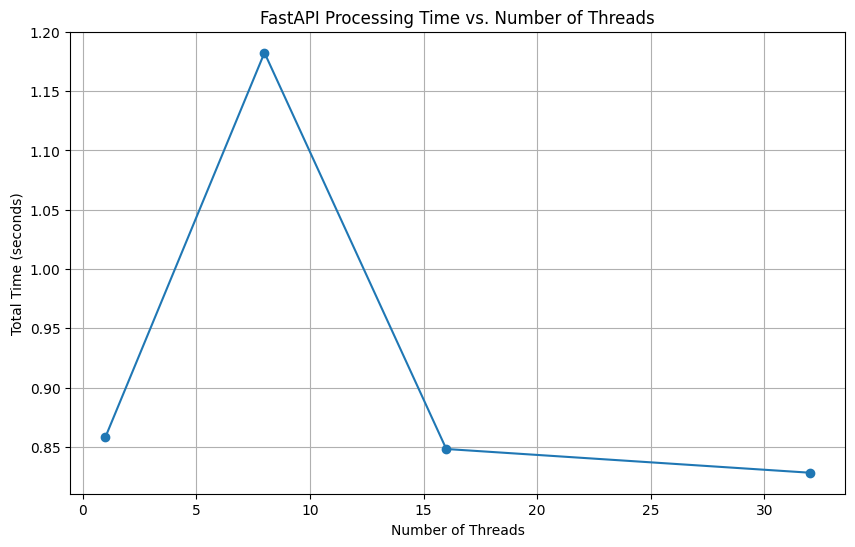

In [36]:
import asyncio
import time
import os
from concurrent.futures import ThreadPoolExecutor
import threading

from fastapi import FastAPI
from pydantic import BaseModel

import httpx
import matplotlib.pyplot as plt

import nest_asyncio
nest_asyncio.apply()

app = FastAPI()

class DataModel(BaseModel):
    data: str

@app.post("/process")
async def process(data_model: DataModel):
    await asyncio.sleep(0.1)  # Simulate I/O-bound operation
    return {"result": f"Processed: {data_model.data}"}

def run_app():
    import uvicorn
    config = uvicorn.Config(app=app, host="127.0.0.1", port=12297, log_level="warning")
    server = uvicorn.Server(config=config)
    app.state.server = server
    server.run()

async def send_requests(num_requests):
    limits = httpx.Limits(max_connections=1000, max_keepalive_connections=100)
    async with httpx.AsyncClient(limits=limits) as client:
        tasks = []
        for i in range(num_requests):
            data = {"data": f"Message {i}"}
            tasks.append(client.post("http://127.0.0.1:12297/process", json=data))
        responses = await asyncio.gather(*tasks)
    return responses

def benchmark_fastapi(cpu_cores):
    num_requests = 100  # Adjust based on your testing needs
    thread_counts = [1, cpu_cores, cpu_cores * 2, min(cpu_cores * 4, 32)]
    results = []

    for threads in thread_counts:
        print(f"\nTesting with {threads} threads.")

        # Update the executor with the current thread count
        executor = ThreadPoolExecutor(max_workers=threads)
        app.state.executor = executor

        # Start the FastAPI app in a separate thread
        server_thread = threading.Thread(target=run_app, daemon=True)
        server_thread.start()
        time.sleep(2)  # Give the server time to start

        # Measure the time to process all requests
        start_time = time.time()

        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
        responses = loop.run_until_complete(send_requests(num_requests))

        total_time = time.time() - start_time
        print(f"Total time for {num_requests} requests: {total_time:.2f} seconds")
        results.append((threads, total_time))

        # Shutdown the server
        app.state.server.should_exit = True
        server_thread.join()

        # Clean up
        executor.shutdown(wait=True)
        loop.close()

    # Plot the results
    thread_counts, times = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(thread_counts, times, marker='o')
    plt.title('FastAPI Processing Time vs. Number of Threads')
    plt.xlabel('Number of Threads')
    plt.ylabel('Total Time (seconds)')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    cpu_cores = os.cpu_count()
    benchmark_fastapi(cpu_cores)
